In [153]:
!pip install pyspark==3.0.1 py4j==0.10.9

In [154]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, when, col
import matplotlib.pyplot as plt

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

Прочитайте CSV файл spark.read.csv()

In [155]:
data = spark.read.csv(
    'bestsellers with categories.csv',
    sep=',',
    header=True,
)

2.	Вивести схему даних за допомогою PrintSchema.

In [156]:
data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)



3.	Вивести назви стовпців і типи даних за допомогою dtypes

In [157]:
data.dtypes

[('Name', 'string'),
 ('Author', 'string'),
 ('User Rating', 'string'),
 ('Reviews', 'string'),
 ('Price', 'string'),
 ('Year', 'string'),
 ('Genre', 'string')]

4.	Виведіть перші п'ять рядків (використовується метод head)

In [158]:
data.head(5)

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating='4.7', Reviews='17350', Price='8', Year='2016', Genre='Non Fiction'),
 Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating='4.6', Reviews='2052', Price='22', Year='2011', Genre='Fiction'),
 Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating='4.7', Reviews='18979', Price='15', Year='2018', Genre='Non Fiction'),
 Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating='4.7', Reviews='21424', Price='6', Year='2017', Genre='Fiction'),
 Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating='4.8', Reviews='7665', Price='12', Year='2019', Genre='Non Fiction')]

5.	Вивести перший рядок за допомогою first()

In [159]:
data.first()

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating='4.7', Reviews='17350', Price='8', Year='2016', Genre='Non Fiction')

6.	Зробіть опис датасету за допомогою describe()

In [160]:
data.describe().show()

+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|summary|                Name|          Author|        User Rating|           Reviews|             Price|              Year|      Genre|
+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|  count|                 550|             550|                550|               550|               550|               550|        550|
|   mean|                null|            null|  4.618363636363641|11953.281818181818|              13.1|            2014.0|       null|
| stddev|                null|            null|0.22698036502519656|11731.132017431892|10.842261978422364|3.1651563841692782|       null|
|    min|"The Plant Parado...|Abraham Verghese|                3.3|             10009|                 0|              2009|    Fiction|
|    max|You Are a Badass:...|    Zhi Gan

7.	Виведіть список стовпців за допомогою columns()

In [161]:
data.columns

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']

8.	Виведіть загальну кількість рядків даних за допомогою count()

In [162]:
data.count()

550

9.	Перевірте, чи у всіх рядків вистачає даних. Якщо є пропуски, замінить їх на NaN, потім тип даних на числовий.

In [163]:
data = data.na.fill('NaN')

10.	Замініть комірки з пропущеними значенями на середні за стовпцем. І тип даних на float. Про скільки книг зберігає дані датасет?

In [164]:
mean_values = data.select([mean(col(column)).alias(column) for column in data.columns if column != 'name']).toPandas().to_dict('records')[0]

# Заміна NaN на середнє значення за стовпцем
for column in mean_values:
    data = data.withColumn(column, when(col(column) == 'NaN', mean_values[column]).otherwise(col(column)))

# Зміна типу на float
for column in data.columns:
    data = data.withColumn(column, data[column].cast('float'))

print("Кількість книг у датасеті:", data.count())

Кількість книг у датасеті: 550


11.	Змініть назви всіх колонок: назва з маленької букви, без пробілів через підкреслення.

In [165]:
data = data.toDF('name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre')

12.	df.columns = ['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre']

In [166]:
data.columns

['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre']

13.	Знайдіть автора з найвищим рейтингом.

In [167]:
top_rating_author = data.orderBy(data.user_rating.desc()).select("author").first()[0]
print("Автор з найвищим рейтингом:", top_rating_author)

Автор з найвищим рейтингом: None


14.	Знайдіть автора з найнижчим рейтингом.

In [168]:
lowest_rating_author = data.orderBy(data.user_rating).select("author").first()[0]
print("Автор з найнижчим рейтингом:", lowest_rating_author)

Автор з найнижчим рейтингом: None


15.	Знайдіть автора, що має найбільшу кількіть рецензій.

In [169]:
most_reviews_author = data.orderBy(data.reviews.desc()).select("author").first()[0]
print("Автор з найбільшою кількістю рецензій:", most_reviews_author)

Автор з найбільшою кількістю рецензій: None


16.	Побудуйте гістограму рейтингу 10 найкращих книг (відібрати книги з найбільшим рейтингом).

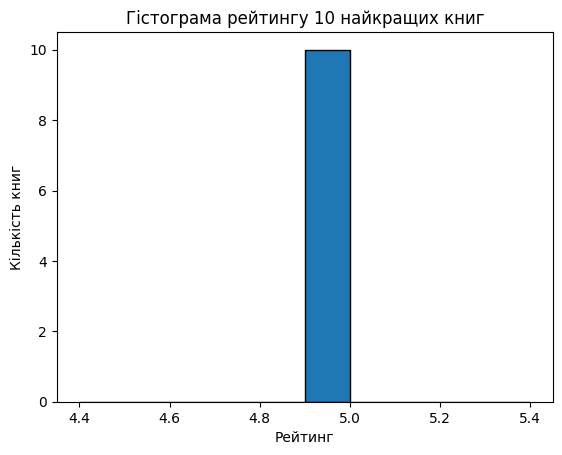

In [170]:
top_10_books = data.orderBy(data['user_rating'].desc()).limit(10)
ratings = top_10_books.select('user_rating').rdd.flatMap(lambda x: x).collect()
plt.hist(ratings, bins=10, edgecolor='black')
plt.xlabel('Рейтинг')
plt.ylabel('Кількість книг')
plt.title('Гістограма рейтингу 10 найкращих книг')
plt.show()

17.	Побудуйте матрицю кореляції для стовпчиків 'user_rating', 'reviews', 'price'.

In [171]:
correlation_matrix = data.select(['user_rating', 'reviews', 'price']).toPandas().corr()
print("Матриця кореляції:")
print(correlation_matrix)

Матриця кореляції:
             user_rating   reviews     price
user_rating     1.000000 -0.001729 -0.133086
reviews        -0.001729  1.000000 -0.109182
price          -0.133086 -0.109182  1.000000
